# Chapter 8. Using convolutions to generalize

## Imports

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import datetime

from torchvision import datasets
from torchvision import transforms

## Data

In [35]:
model_path = "/Users/mattfeng/365-days-of-ml/saved_models"
data_path = "/Volumes/OXYTOCIN/datasets/cifar10"
mean = (0.4913996458053589, 0.48215845227241516, 0.44653093814849854)
std = (0.24703224003314972, 0.24348513782024384, 0.26158785820007324)

# building a dataset using a subset of cifar10
transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

label_map = {0: 0, 2: 1} # cifar10 -> cifar2
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in {0, 2}]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in {0, 2}]

## Convolutions

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3) # 3 input channels, 16 output channels, 3x3 kernel
print(conv)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))


In [4]:
print(conv.weight.shape, conv.bias.shape)
# 16 filters, each with input 3x3x3 (channel, kernel width, kernel height)
# 1 bias per filter

torch.Size([16, 3, 3, 3]) torch.Size([16])


In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need a dimension for batches
print(img.unsqueeze(0).shape, output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


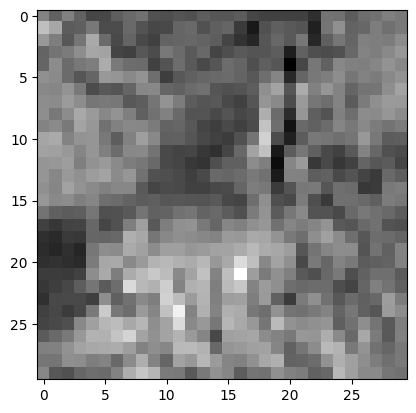

In [6]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### Padding

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel
print(conv)

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need a dimension for batches
print(img.unsqueeze(0).shape, output.shape)


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32])


### Manual filters

#### Blur

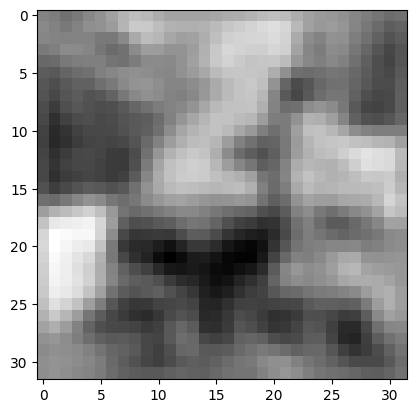

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel

with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

#### Vertical edge detector

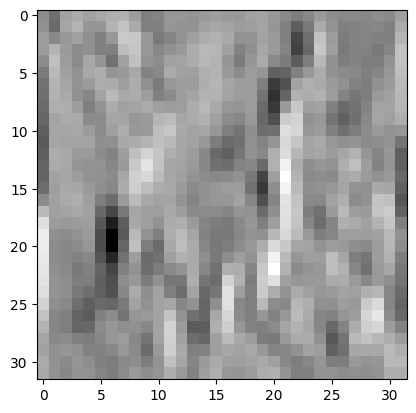

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel

with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]])

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### `MaxPool` Max pooling

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 16, 16])


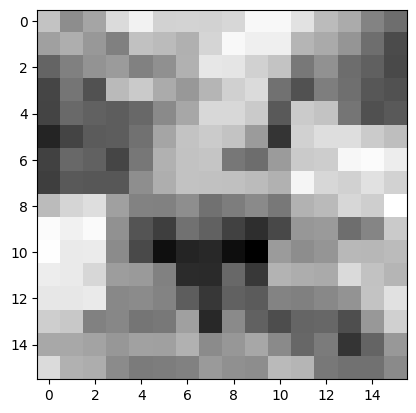

In [10]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

print(img.unsqueeze(0).shape, output.shape)
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### Combining `Conv2d` and  `MaxPool2d`

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # out (16, 32, 32)
    nn.Tanh(),
    nn.MaxPool2d(2),                            # out (16, 16, 16)
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # out (8, 16, 16)
    nn.Tanh(),
    nn.MaxPool2d(2),                            # out (8, 8, 8)
    # need a flatten operation here
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [12]:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


## Subclassing `nn.Module`

In [13]:
class Net(nn.Module):
    # all parameters must be defined in __init__
    # for PyTorch to track them (when we call Module.parameters())
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # out (16, 32, 32)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)                            # out (16, 16, 16)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # out (8, 16, 16)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)                            # out (8, 8, 8)
        
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # reshape
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


## Functional API

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
model = Net()

img, _ = cifar2[0]
model(img.unsqueeze(0))

tensor([[0.1547, 0.2188]], grad_fn=<AddmmBackward0>)

In [28]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader) # average loss per batch
                ))

In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [30]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-01-11 21:39:02.464929 Epoch 1, Training loss 0.5680743810857177
2023-01-11 21:39:23.360175 Epoch 10, Training loss 0.34150097362554754
2023-01-11 21:39:46.559400 Epoch 20, Training loss 0.2999537779836898
2023-01-11 21:40:09.661355 Epoch 30, Training loss 0.2746243792449593
2023-01-11 21:40:32.877342 Epoch 40, Training loss 0.2530979527409669
2023-01-11 21:40:56.190216 Epoch 50, Training loss 0.23633696798496184
2023-01-11 21:41:19.236614 Epoch 60, Training loss 0.22289931275852168
2023-01-11 21:41:42.429869 Epoch 70, Training loss 0.2079803646559928
2023-01-11 21:42:06.571989 Epoch 80, Training loss 0.19585816277440188
2023-01-11 21:42:31.083816 Epoch 90, Training loss 0.18386738614481726
2023-01-11 21:42:55.853262 Epoch 100, Training loss 0.16957332329100863


### Measuring accuracy

In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # get index of highest prediction
                total += labels.shape[0] # batch is zeroth dimension
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.88


### Saving and loading models

In [33]:
torch.save(model.state_dict(), f"{model_path}/birds_vs_airplanes.pt")

In [36]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(f"{model_path}/birds_vs_airplanes.pt"))

<All keys matched successfully>

In [39]:
torch.cuda.is_available()

False